In [3]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

In [19]:
data_directory = './data/lunar/test/data/S12_GradeB/'
test_filename = 'xa.s12.00.mhz.1969-12-16HR00_evid00006'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)
data_cat

,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec),velocity(m/s)
0,1969-12-16T00:00:00.178000,0.000000,0.000000e+00
1,1969-12-16T00:00:00.328943,0.150943,-5.576940e-15
2,1969-12-16T00:00:00.479887,0.301887,-1.115388e-14
3,1969-12-16T00:00:00.630830,0.452830,-1.673082e-14
4,1969-12-16T00:00:00.781774,0.603774,-2.230776e-14
...,...,...,...
572418,1969-12-17T00:00:02.894981,86402.716981,-1.767212e-14
572419,1969-12-17T00:00:03.045925,86402.867925,-2.535490e-14
572420,1969-12-17T00:00:03.196868,86403.018868,-3.008261e-14
572421,1969-12-17T00:00:03.347811,86403.169811,-4.156843e-14


Text(0.5, 1.0, 'xa.s12.00.mhz.1969-12-16HR00_evid00006')

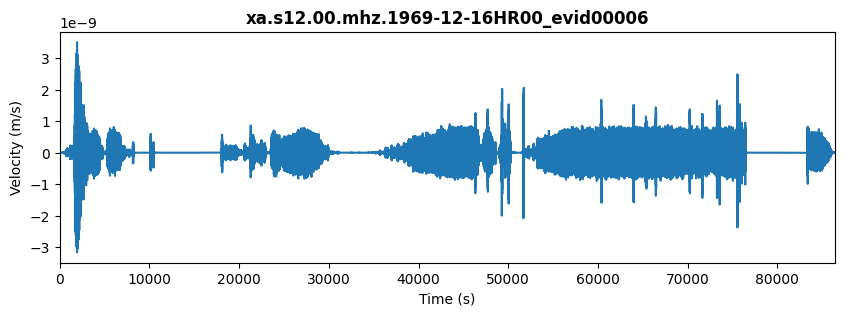

In [20]:
# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
# arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
# ax.legend(handles=[arrival_line])

In [22]:
data_directory = './data/lunar/test/data/S12_GradeB/'
mseed_file = f'{data_directory}{test_filename}.mseed'
st = read(mseed_file)
st

1 Trace(s) in Stream:
XA.S12.00.MHZ | 1969-12-16T00:00:00.178000Z - 1969-12-17T00:00:03.498755Z | 6.6 Hz, 572423 samples

In [23]:
# The stream file also contains some useful header information
st[0].stats

         network: XA
         station: S12
        location: 00
         channel: MHZ
       starttime: 1969-12-16T00:00:00.178000Z
         endtime: 1969-12-17T00:00:03.498755Z
   sampling_rate: 6.625
           delta: 0.1509433962264151
            npts: 572423
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 1136, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 4653056})

In [24]:
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime

In [25]:
tr_times_dt = []
for tr_val in tr_times:
    tr_times_dt.append(starttime + timedelta(seconds=tr_val))

In [14]:
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

Text(0, 0.5, 'Characteristic function')

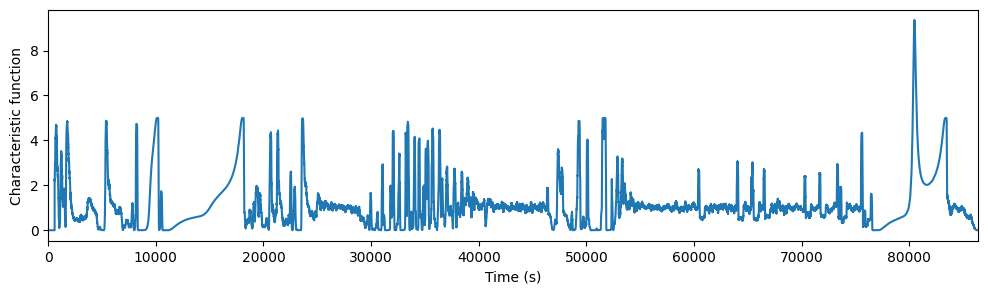

In [26]:
    from obspy.signal.invsim import cosine_taper
    from obspy.signal.filter import highpass
    from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

    # Sampling frequency of our trace
    df = tr.stats.sampling_rate

    # How long should the short-term and long-term window be, in seconds?
    sta_len = 120
    lta_len = 600

    # Run Obspy's STA/LTA t o obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

    # Plot characteristic function
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    ax.plot(tr_times,cft)
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function')

C:\Users\user\AppData\Local\Temp\ipykernel_12116\3817927617.py:41: RuntimeWarning: invalid value encountered in log
  log_sta_lta_cft = np.log(sta_lta_cft + 1)  # Using +1 to avoid log(0)


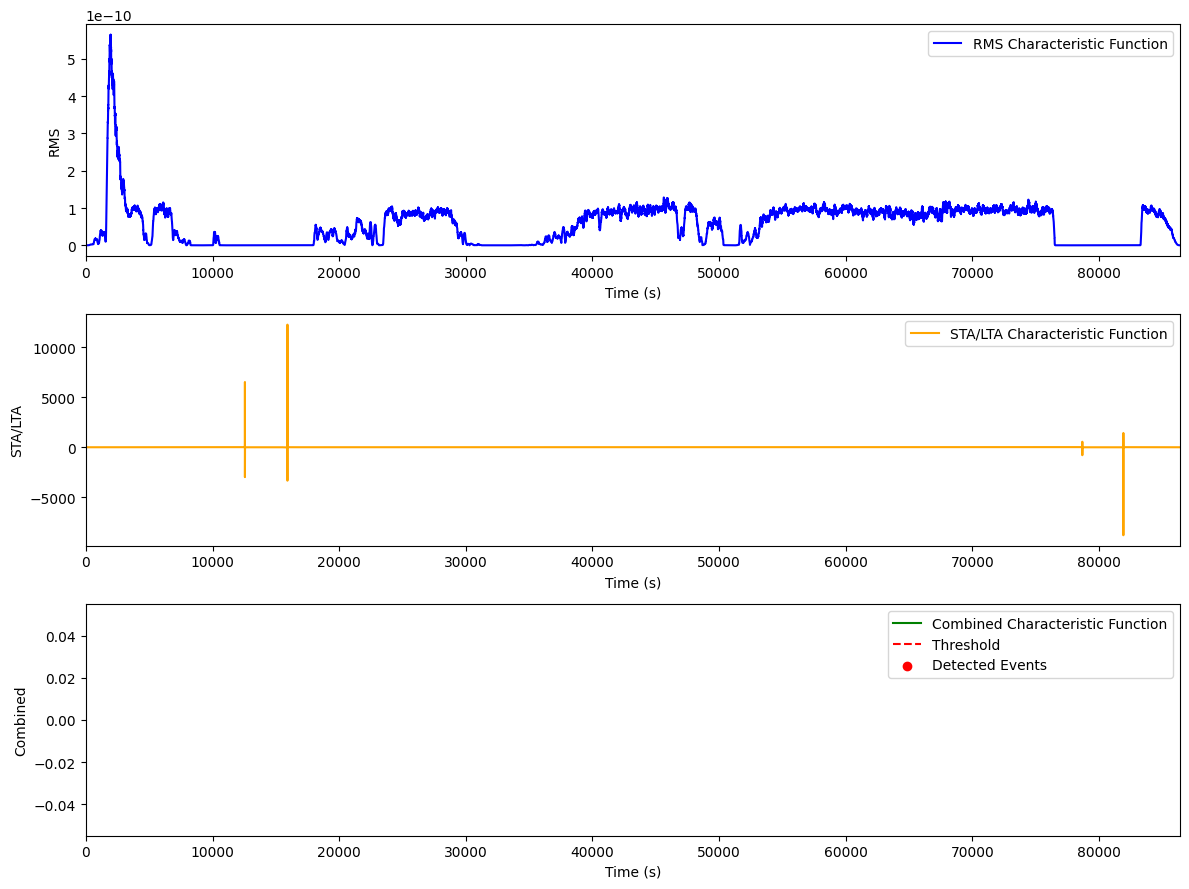

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta

# Sampling frequency of our trace
df = tr.stats.sampling_rate

# Define lengths for RMS and STA/LTA in seconds
rms_window_length = 120  # RMS window length in seconds
sta_len = 120            # Short-term average length in seconds
lta_len = 600            # Long-term average length in seconds

# Convert window lengths to samples
rms_window_samples = int(rms_window_length * df)
sta_samples = int(sta_len * df)
lta_samples = int(lta_len * df)

# Create a function to compute the RMS of a signal over a window
def rms(signal, window_size):
    return np.sqrt(np.convolve(signal**2, np.ones(window_size)/window_size, mode='same'))

# Apply a highpass filter if needed (optional)
tr_filtered = highpass(tr_data, 1.0, df)  # Example filter, 1Hz cutoff

# Calculate RMS characteristic function
rms_cft = rms(tr_filtered, rms_window_samples)

# Calculate STA/LTA characteristic function
sta_lta_cft = classic_sta_lta(tr_filtered, sta_samples, lta_samples)

# Combine the two characteristic functions (Ensemble Method)

# normalized_rms_cft = (rms_cft - np.min(rms_cft)) / (np.max(rms_cft) - np.min(rms_cft))
# normalized_sta_lta_cft = (sta_lta_cft - np.min(sta_lta_cft)) / (np.max(sta_lta_cft) - np.min(sta_lta_cft))

# # Combine the two normalized characteristic functions with weights
# combined_cft = 0.5 * normalized_rms_cft + 0.5 * normalized_sta_lta_cft
# Apply logarithmic transformation (add a small value to avoid log(0))
log_sta_lta_cft = np.log(sta_lta_cft + 1)  # Using +1 to avoid log(0)

# Normalize RMS
normalized_rms_cft = (rms_cft - np.min(rms_cft)) / (np.max(rms_cft) - np.min(rms_cft))

# Combine using a weighted approach
combined_cft = 0.5 * normalized_rms_cft + 0.5 * (log_sta_lta_cft - np.min(log_sta_lta_cft)) / (np.max(log_sta_lta_cft) - np.min(log_sta_lta_cft))



# Threshold for detecting seismic events (example value)
threshold = 1

# Detect events based on combined characteristic function
event_indices = np.where(combined_cft > threshold)[0]

# Plot the results
fig, ax = plt.subplots(3, 1, figsize=(12, 9))

# Plot RMS characteristic function
ax[0].plot(tr_times, rms_cft, label='RMS Characteristic Function', color='blue')
ax[0].set_xlim([min(tr_times), max(tr_times)])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('RMS')
ax[0].legend()

# Plot STA/LTA characteristic function
ax[1].plot(tr_times, sta_lta_cft, label='STA/LTA Characteristic Function', color='orange')
ax[1].set_xlim([min(tr_times), max(tr_times)])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('STA/LTA')
ax[1].legend()

# Plot combined characteristic function
ax[2].plot(tr_times, combined_cft, label='Combined Characteristic Function', color='green')
ax[2].axhline(threshold, color='red', linestyle='--', label='Threshold')
ax[2].scatter(tr_times[event_indices], combined_cft[event_indices], color='red', label='Detected Events')
ax[2].set_xlim([min(tr_times), max(tr_times)])
ax[2].set_xlabel('Time (s)')
ax[2].set_ylabel('Combined')
ax[2].legend()

plt.tight_layout()
plt.show()

In [38]:
print(combined_cft)

[0.20889829 0.20889829 0.20889829 ... 0.20890607 0.20890597 0.20890579]


Text(0, 0.5, 'Characteristic function')

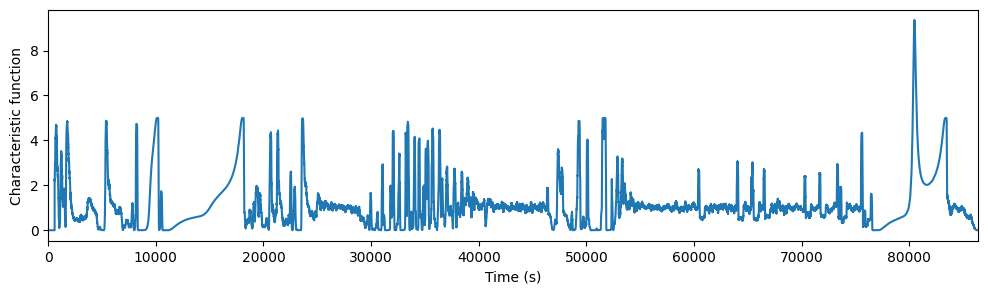

In [28]:
    from obspy.signal.invsim import cosine_taper
    from obspy.signal.filter import highpass
    from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

    # Sampling frequency of our trace
    df = tr.stats.sampling_rate

    # How long should the short-term and long-term window be, in seconds?
    sta_len = 120
    lta_len = 600

    # Run Obspy's STA/LTA t o obtain a characteristic function
    # This function basically calculates the ratio of amplitude between the short-term 
    # and long-term windows, moving consecutively in time across the data
    cft = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

    # Plot characteristic function
    fig,ax = plt.subplots(1,1,figsize=(12,3))
    ax.plot(tr_times,cft)
    ax.set_xlim([min(tr_times),max(tr_times)])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Characteristic function') 

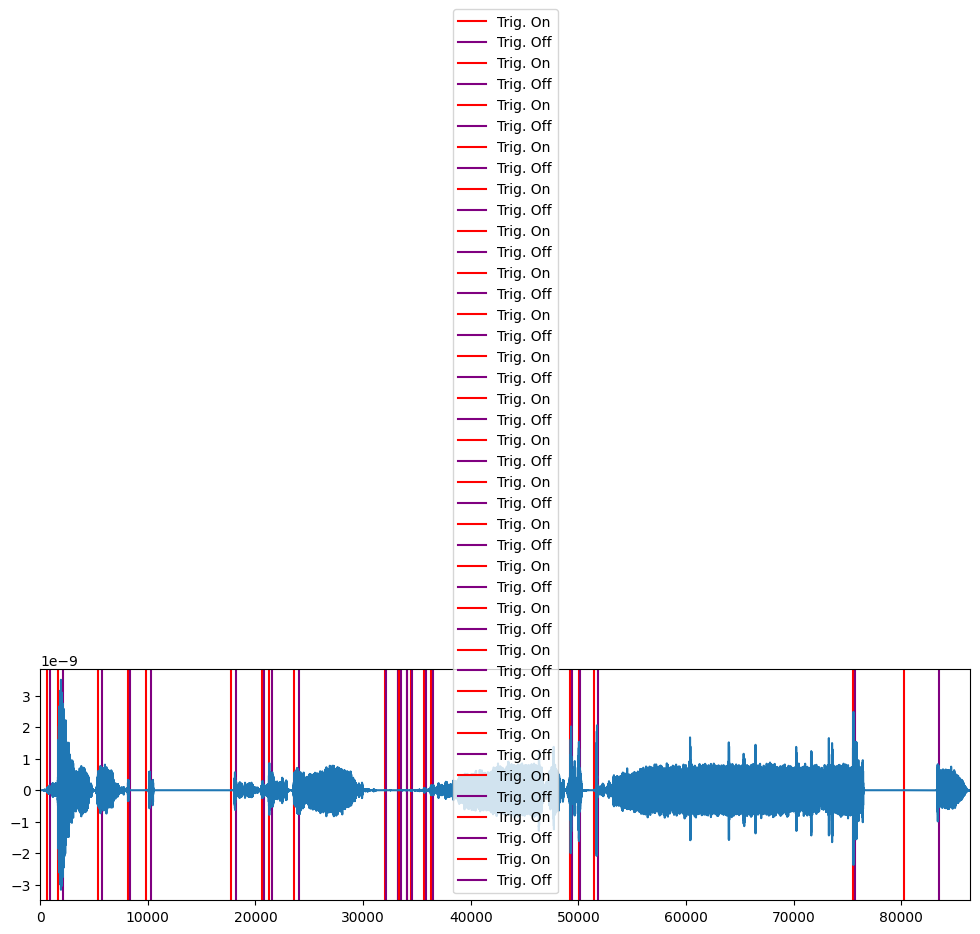

In [29]:
# Play around with the on and off triggers, based on values in the characteristic function
thr_on = 4
thr_off = 1.5
on_off = np.array(trigger_onset(cft, thr_on, thr_off))
# The first column contains the indices where the trigger is turned "on". 
# The second column contains the indices where the trigger is turned "off".

# Plot on and off triggers
fig,ax = plt.subplots(1,1,figsize=(12,3))
for i in np.arange(0,len(on_off)):
    triggers = on_off[i]
    ax.axvline(x = tr_times[triggers[0]], color='red', label='Trig. On')
    ax.axvline(x = tr_times[triggers[1]], color='purple', label='Trig. Off')

# Plot seismogram
ax.plot(tr_times,tr_data)
ax.set_xlim([min(tr_times),max(tr_times)])
ax.legend()